## Facial Recognition using PCA and SVM




In [33]:
#importing the required modules

from time import time
import logging
import pylab as pl
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [5]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [7]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)
print(n_samples, h, w)

1288 50 37


In [10]:
# x
x = lfw_people.data
n_features = x.shape[1]
#X.shape --> (no of images, no of features in each)

In [13]:
# y 
y = lfw_people.target
target_names = lfw_people.target_names
# target_names -->['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
# 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']

n_classes = target_names.shape[0]
#target_names.shape --> (7,)

In [14]:
# splitting into training and testing set 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [63]:
# dimensionality reduction
n_components = 150
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(x_train)
print((time() - t0))
print(pca.explained_variance_ratio_)

0.1804499626159668
[0.19346516 0.15116856 0.07083688 0.05951796 0.05157499 0.02887156
 0.02514484 0.02176465 0.02019381 0.01902125 0.01682213 0.01580599
 0.01223364 0.01087938 0.01064452 0.00979654 0.00892399 0.00854844
 0.00835712 0.00722635 0.00696569 0.00653857 0.00639558 0.00561317
 0.00531107 0.00520152 0.00507466 0.00484209 0.00443588 0.0041783
 0.00393705 0.00381728 0.00356061 0.00351201 0.00334556 0.00329931
 0.00314626 0.00296217 0.00290136 0.00284723 0.00280004 0.00267556
 0.00259901 0.00258401 0.00240919 0.00238994 0.00235403 0.00222587
 0.00217508 0.00216566 0.00209064 0.00205426 0.00200421 0.00197395
 0.0019383  0.00188764 0.00180173 0.00178897 0.00174819 0.00173054
 0.00165646 0.00162947 0.00157409 0.00153429 0.00149965 0.00147262
 0.00143931 0.00141882 0.00139698 0.00138147 0.00134005 0.00133168
 0.00128812 0.00125593 0.00124247 0.00121864 0.00120946 0.00118304
 0.00115092 0.00113678 0.00112625 0.00111618 0.00109398 0.00107177
 0.0010567  0.0010436  0.00102395 0.00101689

In [64]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [65]:
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

In [66]:
# Training
t0 = time()
print("Fitting the classifier to the training set")
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid) 
#methodically build and evaluate a model 
#for each combination of algorithm parameters specified in a grid, and return the best estimator 
#in clf.best_estimator. 
clf = clf.fit(x_train_pca, y_train)
print('Time:',(time() - t0),'s')
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Time: 31.12398624420166 s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [60]:
# Predicting 

print("Predicting the people names on the testing set")
y_pred = clf.predict(x_test_pca)

Predicting the people names on the testing set


In [61]:
# Accuracy
acc = accuracy_score(y_test,y_pred)
print('Accuracy:',acc)

Accuracy: 0.7267080745341615


In [62]:
# Classification_Report 

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.77      0.62        13
     Colin Powell       0.66      0.87      0.75        60
  Donald Rumsfeld       0.57      0.63      0.60        27
    George W Bush       0.87      0.75      0.80       146
Gerhard Schroeder       0.59      0.52      0.55        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.74      0.69      0.71        36

         accuracy                           0.73       322
        macro avg       0.66      0.68      0.66       322
     weighted avg       0.74      0.73      0.73       322



In [43]:
# Plotting 

#title
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# plotting
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i*4].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i*4], size=12)
        plt.xticks(())
        plt.yticks(())

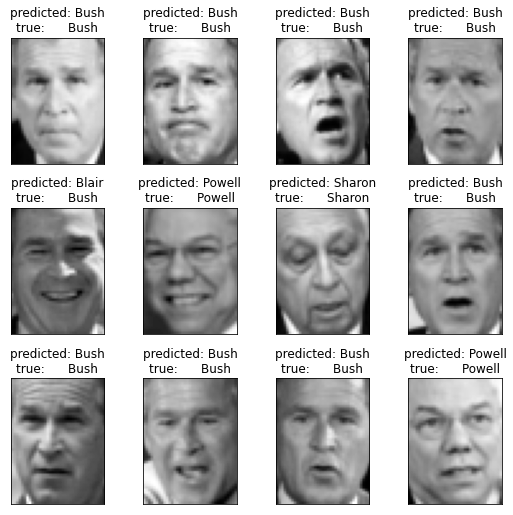

In [44]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
plot_gallery(x_test, prediction_titles, h, w)

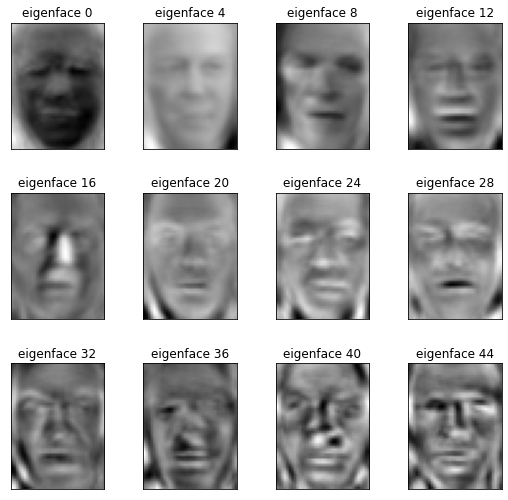

In [45]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

#### Ref: 
###### Udacity Intro to ML
##### https://towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16